In [24]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [26]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [27]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [28]:
tf.keras.backend.clear_session()

In [29]:
subject = 'Tocantins - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [30]:
data = pd.read_csv('2003_mo_model_input_TO.csv')
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data =data.drop([' NFSP - Fluxo Mensal (Milhões de reais)'], axis=1)
data

,Unnamed: 0,Tocantins- custo m2 (R$),Tocantins - Desemprego,Tocantins - IDH Educacao,Tocantins - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),...,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Tocantins - IDH,Tocantins - Consumo de Cimento (t)
0,2003-1,11275.335200,8.243830,0.674633,0.766370,3.576410,978.531801,1343.371397,26.858971,18.470168,...,3.656420,0.969649,0.724032,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.700107,17.555
1,2003-2,11378.766738,8.237931,0.675135,0.766735,3.573972,978.532153,1343.394931,26.860534,18.468827,...,3.654697,0.950783,0.690297,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.700487,14.976
2,2003-3,11476.693775,8.232033,0.675638,0.767100,3.572551,978.532357,1343.408659,26.861445,18.468045,...,3.654266,0.938332,0.669681,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.700866,13.334
3,2003-4,11568.023775,8.226135,0.676140,0.767465,3.572398,978.532379,1343.410130,26.861543,18.467962,...,3.653595,0.926401,0.660494,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.701246,15.173
4,2003-5,11656.641017,8.220236,0.676642,0.767830,3.576238,978.439851,1339.493279,26.838338,18.686479,...,3.650266,0.951683,0.648337,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.701626,18.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,36946.428021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,36910.472628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,36863.430304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,36780.869880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


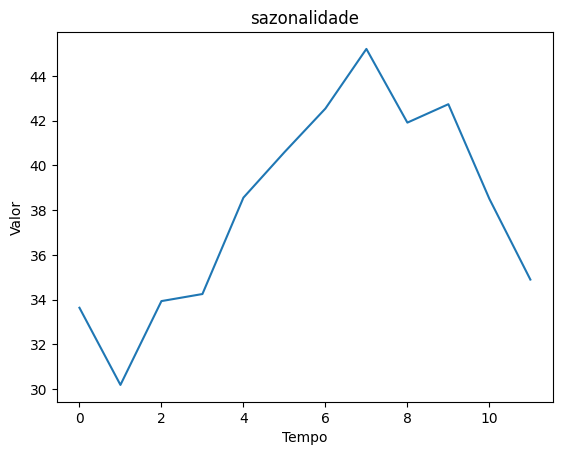

,sazonalidade
sazonalidade,
0,33.636260
1,30.187922
2,33.933686
3,34.249380
4,38.555589
5,40.585725
6,42.537272
7,45.201810
8,41.908976


In [31]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [32]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Tocantins- custo m2 (R$),Tocantins - Desemprego,Tocantins - IDH Educacao,Tocantins - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),...,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Tocantins - IDH,sazonalidade,Tocantins - Consumo de Cimento (t)
0,2003-1,11275.335200,8.243830,0.674633,0.766370,3.576410,978.531801,1343.371397,26.858971,18.470168,...,0.969649,0.724032,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.700107,33.636260,17.555
1,2003-2,11378.766738,8.237931,0.675135,0.766735,3.573972,978.532153,1343.394931,26.860534,18.468827,...,0.950783,0.690297,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.700487,30.187922,14.976
2,2003-3,11476.693775,8.232033,0.675638,0.767100,3.572551,978.532357,1343.408659,26.861445,18.468045,...,0.938332,0.669681,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.700866,33.933686,13.334
3,2003-4,11568.023775,8.226135,0.676140,0.767465,3.572398,978.532379,1343.410130,26.861543,18.467962,...,0.926401,0.660494,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.701246,34.249380,15.173
4,2003-5,11656.641017,8.220236,0.676642,0.767830,3.576238,978.439851,1339.493279,26.838338,18.686479,...,0.951683,0.648337,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.701626,38.555589,18.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,36946.428021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.555589,NaN
245,2023-6,36910.472628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.585725,NaN
246,2023-7,36863.430304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.537272,NaN
247,2023-8,36780.869880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.201810,NaN


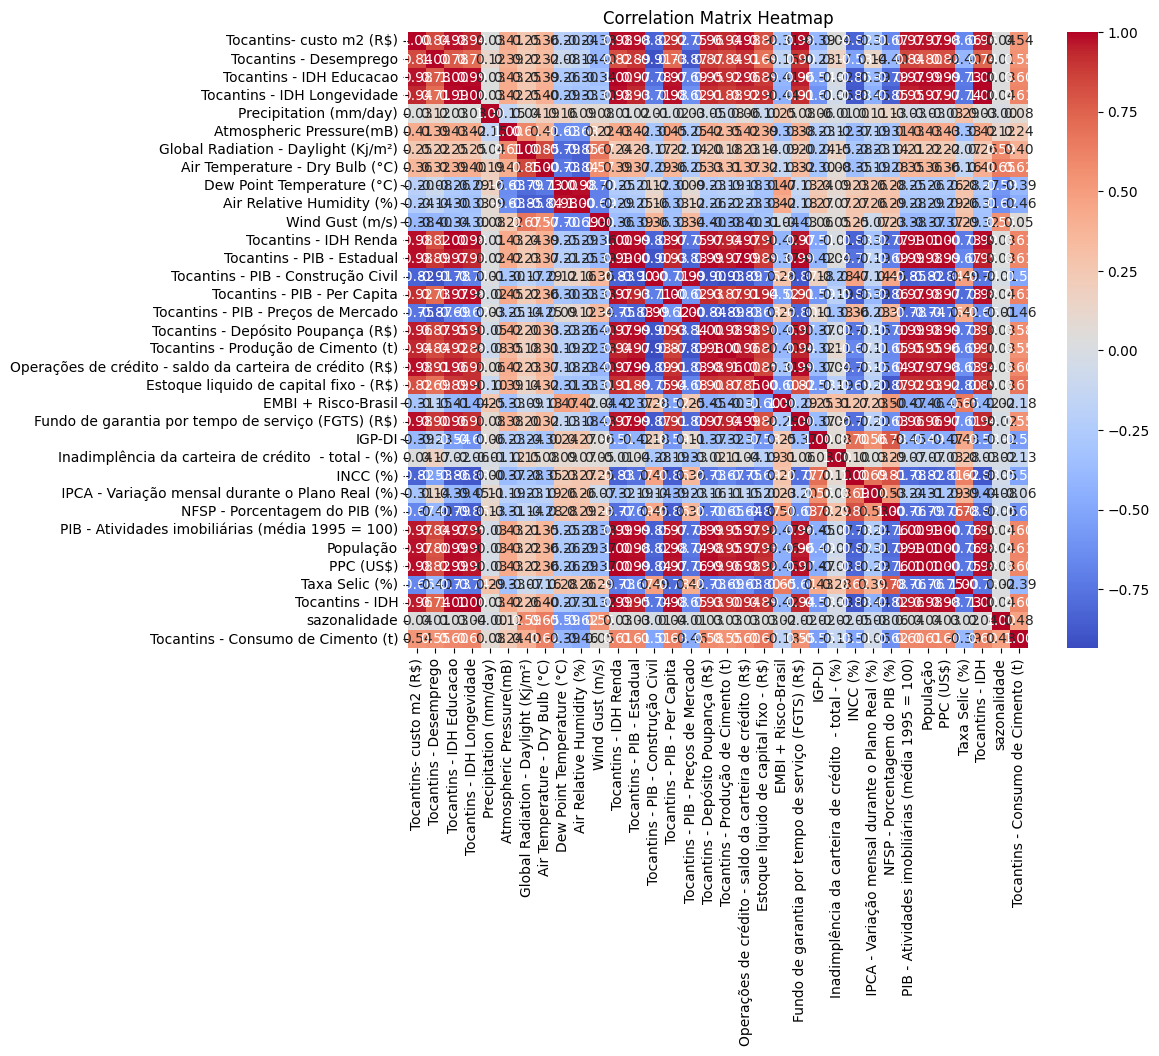

In [33]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [34]:
data =data.drop(['Precipitation (mm/day)',
                 'Wind Gust (m/s)'], axis=1)
data

,Unnamed: 0,Tocantins- custo m2 (R$),Tocantins - Desemprego,Tocantins - IDH Educacao,Tocantins - IDH Longevidade,Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),...,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Tocantins - IDH,sazonalidade,Tocantins - Consumo de Cimento (t)
0,2003-1,11275.335200,8.243830,0.674633,0.766370,978.531801,1343.371397,26.858971,18.470168,64.274735,...,0.969649,0.724032,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.700107,33.636260,17.555
1,2003-2,11378.766738,8.237931,0.675135,0.766735,978.532153,1343.394931,26.860534,18.468827,64.266609,...,0.950783,0.690297,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.700487,30.187922,14.976
2,2003-3,11476.693775,8.232033,0.675638,0.767100,978.532357,1343.408659,26.861445,18.468045,64.261870,...,0.938332,0.669681,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.700866,33.933686,13.334
3,2003-4,11568.023775,8.226135,0.676140,0.767465,978.532379,1343.410130,26.861543,18.467962,64.261362,...,0.926401,0.660494,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.701246,34.249380,15.173
4,2003-5,11656.641017,8.220236,0.676642,0.767830,978.439851,1339.493279,26.838338,18.686479,65.145668,...,0.951683,0.648337,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.701626,38.555589,18.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,36946.428021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.555589,NaN
245,2023-6,36910.472628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.585725,NaN
246,2023-7,36863.430304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.537272,NaN
247,2023-8,36780.869880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.201810,NaN


In [35]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,Tocantins- custo m2 (R$),Tocantins - Desemprego,Tocantins - IDH Educacao,Tocantins - IDH Longevidade,Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Tocantins - IDH Renda,...,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Tocantins - IDH,sazonalidade
0,-1.556550,-0.738973,-2.068480,-2.377286,-0.104063,-0.080672,-0.433657,-0.072396,0.020401,-1.968620,...,1.258423,3.122582,2.723741,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-2.226834,-0.998018
1,-1.533428,-0.745082,-2.037231,-2.332765,-0.103596,-0.080378,-0.431805,-0.073028,0.019502,-1.942437,...,1.252755,2.970356,2.350880,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-2.188140,-1.772962
2,-1.511537,-0.751192,-2.005981,-2.288244,-0.103323,-0.080206,-0.430724,-0.073397,0.018978,-1.916253,...,1.251338,2.869895,2.123016,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-2.149447,-0.931177
3,-1.491121,-0.757301,-1.974731,-2.243723,-0.103294,-0.080188,-0.430608,-0.073436,0.018921,-1.890069,...,1.249134,2.773628,2.021477,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-2.110754,-0.860231
4,-1.471312,-0.763410,-1.943481,-2.199202,-0.226485,-0.129112,-0.458117,0.029568,0.116790,-1.863885,...,1.238186,2.977624,1.887113,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-2.072060,0.107502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.765401,0.745989,1.365281,1.133508,0.452807,0.930257,1.021501,-0.696537,-0.826295,1.299630,...,-0.685819,-1.749976,-2.010387,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.307164,1.601106
188,1.788520,0.733597,1.360281,1.116965,0.008221,0.180352,0.634441,-0.200242,-0.347563,1.298477,...,-0.770458,-1.593005,-1.870713,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.296751,0.861108
189,1.813048,0.721205,1.355281,1.100422,0.107068,-0.499010,-0.036005,0.385101,0.292894,1.297323,...,-0.910077,-1.351489,-1.806230,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.286338,1.045939
190,1.838403,0.708813,1.350281,1.083880,0.174255,-0.888757,-0.427517,0.654398,0.637521,1.296170,...,-1.020687,-1.198492,-1.727496,-0.640956,1.463901,1.398006,1.446142,-1.400787,1.275925,0.095749


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      19.115
1      22.973
2      30.126
3      29.497
4      29.528
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Tocantins - Consumo de Cimento (t), Length: 249, dtype: float64

In [37]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Tocantins- custo m2 (R$),Tocantins - Desemprego,Tocantins - IDH Educacao,Tocantins - IDH Longevidade,Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Tocantins - IDH Renda,...,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Tocantins - IDH,sazonalidade
0,-1.556550,-0.738973,-2.068480,-2.377286,-0.104063,-0.080672,-0.433657,-0.072396,0.020401,-1.968620,...,1.258423,3.122582,2.723741,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-2.226834,-0.998018
1,-1.533428,-0.745082,-2.037231,-2.332765,-0.103596,-0.080378,-0.431805,-0.073028,0.019502,-1.942437,...,1.252755,2.970356,2.350880,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-2.188140,-1.772962
2,-1.511537,-0.751192,-2.005981,-2.288244,-0.103323,-0.080206,-0.430724,-0.073397,0.018978,-1.916253,...,1.251338,2.869895,2.123016,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-2.149447,-0.931177
3,-1.491121,-0.757301,-1.974731,-2.243723,-0.103294,-0.080188,-0.430608,-0.073436,0.018921,-1.890069,...,1.249134,2.773628,2.021477,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-2.110754,-0.860231
4,-1.471312,-0.763410,-1.943481,-2.199202,-0.226485,-0.129112,-0.458117,0.029568,0.116790,-1.863885,...,1.238186,2.977624,1.887113,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-2.072060,0.107502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.151701,1.443839,1.358497,1.453376,0.302280,0.800604,1.206866,0.826311,0.274850,1.293608,...,0.749349,-0.883659,-0.214006,-0.607704,0.952667,1.031384,1.044043,0.043807,1.403526,-1.772962
158,1.173322,1.400830,1.361640,1.446746,0.966363,0.374186,0.880513,0.715431,0.271331,1.291836,...,0.977327,-0.950771,-0.434717,-0.620523,0.954843,1.042716,1.056960,0.210856,1.404858,-0.931177
159,1.195742,1.357822,1.364783,1.440117,1.400108,0.984187,1.083272,-0.013322,-0.365673,1.290063,...,1.048267,-1.028465,-0.524091,-0.631530,0.957019,1.054049,1.070172,0.107070,1.406191,-0.860231
160,1.218107,1.314814,1.367926,1.433488,1.832031,1.484633,1.520490,-0.769225,-1.041921,1.288291,...,1.048868,-1.103668,-0.614500,-0.640320,0.956331,1.065381,1.083626,0.392942,1.407523,0.107502


In [38]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.115
1      22.973
2      30.126
3      29.497
4      29.528
        ...  
157    33.787
158    41.594
159    36.019
160    45.143
161    41.704
Name: Tocantins - Consumo de Cimento (t), Length: 162, dtype: float64

In [39]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [40]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 31)

In [41]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Tocantins- custo m2 (R$),Tocantins - Desemprego,Tocantins - IDH Educacao,Tocantins - IDH Longevidade,Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Tocantins - IDH Renda,...,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Tocantins - IDH,sazonalidade
126,0.444176,1.088278,0.495030,0.380422,0.718846,1.001136,1.470099,-1.232146,-1.426457,0.677921,...,-0.155884,0.045243,0.888984,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.413591,1.002305
127,0.465971,1.120223,0.505332,0.379589,0.008838,0.784403,1.387399,-1.049092,-1.244655,0.678724,...,-0.349984,0.061828,0.954254,-0.440372,0.923198,0.664707,0.706933,-0.649312,0.418361,1.601106
128,0.488632,1.152168,0.515634,0.378757,-0.444818,-0.038088,0.865802,-0.500967,-0.674794,0.679527,...,-0.529294,0.046225,1.045217,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.423132,0.861108
129,0.509741,1.184114,0.525936,0.377925,-0.583676,-0.783493,-0.102612,-0.022930,-0.027975,0.680330,...,-0.788101,0.032522,1.176395,-0.397019,0.941953,0.691327,0.723490,-1.288807,0.427902,1.045939
130,0.530190,1.216059,0.536238,0.377093,-0.786152,-1.537298,-1.003428,0.307942,0.522084,0.681132,...,-1.020394,0.042757,1.303259,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.432672,0.095749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.765401,0.745989,1.365281,1.133508,0.452807,0.930257,1.021501,-0.696537,-0.826295,1.299630,...,-0.685819,-1.749976,-2.010387,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.307164,1.601106
188,1.788520,0.733597,1.360281,1.116965,0.008221,0.180352,0.634441,-0.200242,-0.347563,1.298477,...,-0.770458,-1.593005,-1.870713,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.296751,0.861108
189,1.813048,0.721205,1.355281,1.100422,0.107068,-0.499010,-0.036005,0.385101,0.292894,1.297323,...,-0.910077,-1.351489,-1.806230,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.286338,1.045939
190,1.838403,0.708813,1.350281,1.083880,0.174255,-0.888757,-0.427517,0.654398,0.637521,1.296170,...,-1.020687,-1.198492,-1.727496,-0.640956,1.463901,1.398006,1.446142,-1.400787,1.275925,0.095749


In [42]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 31)

In [43]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [44]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [45]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [46]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3279964128, 2364091796, 3338299547, 2591347115, 4145901833, 1290651682, 3805509978, 1219026367, 1110630165, 2362646592, 4171203927, 3629786217, 3758629776, 3571486176, 746240796, 3432492421, 3351316465, 2686389680, 2674994514, 1402156466, 302758527, 1069322354, 842157152, 2494052682, 620748574, 2312658429, 2878500544, 2510520334, 1798395201, 286205741, 608128123, 2112185868, 2636437189, 256731567, 3679593465, 3968183204, 2841863918, 1350549608, 1270094257, 1386034854, 4113256210, 1217215912, 279697185, 2003883837, 619541414, 91267495, 1126970785, 2208676343, 3912482344, 2167499914]


Step: 0 ___________________________________________
val_loss: 13.916565895080566
winner_seed: 3279964128


Step: 1 ___________________________________________
val_loss: 15.39376163482666


Step: 2 ___________________________________________
val_loss: 14.40814208984375


Step: 3 ___________________________________________
val_loss: 14.177184104919434


Step: 4 ___________________________________________
va

In [47]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 141ms/step - loss: 1531.9696 - val_loss: 56.9340
Epoch 2/10000
4/4 [==============================] - 0s 13ms/step - loss: 64.6487 - val_loss: 58.0854
Epoch 3/10000
4/4 [==============================] - 0s 14ms/step - loss: 54.5202 - val_loss: 40.4268
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 55.5605 - val_loss: 45.4336
Epoch 5/10000
4/4 [==============================] - 0s 14ms/step - loss: 48.9049 - val_loss: 38.4508
Epoch 6/10000
4/4 [==============================] - 0s 13ms/step - loss: 46.8699 - val_loss: 37.9277
Epoch 7/10000
4/4 [==============================] - 0s 14ms/step - loss: 41.5450 - val_loss: 34.4631
Epoch 8/10000
4/4 [==============================] - 0s 13ms/step - loss: 39.2442 - val_loss: 40.3636
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 47.2252 - val_loss: 33.4494
Epoch 10/10000
4/4 [==============================] - 0s 14ms/step - loss: 40.2

4/4 [==============================] - 0s 13ms/step - loss: 12.3396 - val_loss: 14.6599
Epoch 81/10000
4/4 [==============================] - 0s 14ms/step - loss: 10.7990 - val_loss: 20.8156
Epoch 82/10000
4/4 [==============================] - 0s 13ms/step - loss: 15.2905 - val_loss: 12.6518
Epoch 83/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.9810 - val_loss: 31.3431
Epoch 84/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.9924 - val_loss: 15.5310
Epoch 85/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.8569 - val_loss: 17.1302
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.3066 - val_loss: 22.6383
Epoch 87/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.5065 - val_loss: 23.3215
Epoch 88/10000
4/4 [==============================] - 0s 15ms/step - loss: 13.6968 - val_loss: 19.8455
Epoch 89/10000
4/4 [==============================] - 0s 14ms/step - loss: 9.1253 - val_lo

4/4 [==============================] - 0s 13ms/step - loss: 10.8487 - val_loss: 12.5801
Epoch 160/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.1590 - val_loss: 18.7055
Epoch 161/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.1350 - val_loss: 18.5103
Epoch 162/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.2351 - val_loss: 16.7581
Epoch 163/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.1099 - val_loss: 15.7711
Epoch 164/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.3758 - val_loss: 14.3024
Epoch 165/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.7924 - val_loss: 14.0539
Epoch 166/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.7370 - val_loss: 33.6305
Epoch 167/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.1910 - val_loss: 23.7442
Epoch 168/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.2334 - 

4/4 [==============================] - 0s 13ms/step - loss: 7.5880 - val_loss: 23.7923
Epoch 239/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.3718 - val_loss: 15.7939
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8638 - val_loss: 16.5797
Epoch 241/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.0519 - val_loss: 14.6717
Epoch 242/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.2426 - val_loss: 15.2584
Epoch 243/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.9675 - val_loss: 17.8109
Epoch 244/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.4013 - val_loss: 14.8900
Epoch 245/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.9687 - val_loss: 14.7180
Epoch 246/10000
4/4 [==============================] - 0s 14ms/step - loss: 7.6777 - val_loss: 13.7972
Epoch 247/10000
4/4 [==============================] - 0s 14ms/step - loss: 8.1865 - val_

4/4 [==============================] - 0s 13ms/step - loss: 7.2965 - val_loss: 29.1953
Epoch 318/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.8205 - val_loss: 18.2506
Epoch 319/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.5352 - val_loss: 14.1154
Epoch 320/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.5504 - val_loss: 18.0063
Epoch 321/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.3176 - val_loss: 16.2682
Epoch 322/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.1549 - val_loss: 12.9921
Epoch 323/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.0800 - val_loss: 15.1166
Epoch 324/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.7094 - val_loss: 12.4006
Epoch 325/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.3366 - val_loss: 15.8618
Epoch 326/10000
4/4 [==============================] - 0s 14ms/step - loss: 8.2127 - val_

4/4 [==============================] - 0s 12ms/step - loss: 6.6356 - val_loss: 20.2497
Epoch 397/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.6746 - val_loss: 17.2744
Epoch 398/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.4775 - val_loss: 19.3287
Epoch 399/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.7632 - val_loss: 20.3447
Epoch 400/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.7937 - val_loss: 17.0964
Epoch 401/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.4016 - val_loss: 15.0620
Epoch 402/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.5822 - val_loss: 20.4221
Epoch 403/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.7453 - val_loss: 18.8376
Epoch 404/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5669 - val_loss: 23.8164
Epoch 405/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.2417 - val_

4/4 [==============================] - 0s 13ms/step - loss: 6.4156 - val_loss: 22.9452
Epoch 476/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.4315 - val_loss: 15.5147
Epoch 477/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.7612 - val_loss: 21.5421
Epoch 478/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.7961 - val_loss: 28.2566
Epoch 479/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.3893 - val_loss: 15.4749
Epoch 480/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.0797 - val_loss: 24.0690
Epoch 481/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.9428 - val_loss: 13.9039
Epoch 482/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.2930 - val_loss: 25.7029
Epoch 483/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.3088 - val_loss: 15.8240
Epoch 484/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.0229 - val_

4/4 [==============================] - 0s 12ms/step - loss: 6.6469 - val_loss: 23.7672
Epoch 555/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.2947 - val_loss: 19.0846
Epoch 556/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.9317 - val_loss: 22.9428
Epoch 557/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.2314 - val_loss: 16.2009
Epoch 558/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4151 - val_loss: 16.9606
Epoch 559/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0670 - val_loss: 17.3393
Epoch 560/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4496 - val_loss: 15.3828
Epoch 561/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.9337 - val_loss: 17.5035
Epoch 562/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.2424 - val_loss: 16.0877
Epoch 563/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.7464 - val_

4/4 [==============================] - 0s 13ms/step - loss: 6.5326 - val_loss: 14.7376
Epoch 634/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.7338 - val_loss: 15.6070
Epoch 635/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.8069 - val_loss: 21.7253
Epoch 636/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.2845 - val_loss: 16.1960
Epoch 637/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.8747 - val_loss: 16.6531
Epoch 638/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5793 - val_loss: 17.8838
Epoch 639/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.3905 - val_loss: 18.8203
Epoch 640/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.0491 - val_loss: 15.5315
Epoch 641/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.9102 - val_loss: 15.0540
Epoch 642/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.2171 - val_

4/4 [==============================] - 0s 13ms/step - loss: 5.9094 - val_loss: 26.4429
Epoch 713/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.9313 - val_loss: 15.5485
Epoch 714/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.8982 - val_loss: 15.6731
Epoch 715/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.7029 - val_loss: 24.4343
Epoch 716/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.3681 - val_loss: 15.2338
Epoch 717/10000
4/4 [==============================] - 0s 14ms/step - loss: 7.0072 - val_loss: 22.9868
Epoch 718/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.6518 - val_loss: 16.3117
Epoch 719/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.2487 - val_loss: 24.3492
Epoch 720/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.3753 - val_loss: 19.1154
Epoch 721/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.0668 - val_

4/4 [==============================] - 0s 14ms/step - loss: 6.1533 - val_loss: 17.7166
Epoch 792/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.0349 - val_loss: 14.8336
Epoch 793/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.3422 - val_loss: 32.0163
Epoch 794/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.4090 - val_loss: 19.0261
Epoch 795/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.2331 - val_loss: 18.0005
Epoch 796/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.2487 - val_loss: 14.9560
Epoch 797/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.7758 - val_loss: 21.0452
Epoch 798/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.9901 - val_loss: 14.9105
Epoch 799/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.8213 - val_loss: 16.5594
Epoch 800/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.8798 - val_

4/4 [==============================] - 0s 13ms/step - loss: 4.9716 - val_loss: 21.5480
Epoch 871/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.9351 - val_loss: 21.4842
Epoch 872/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6252 - val_loss: 17.4836
Epoch 873/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.7970 - val_loss: 19.5604
Epoch 874/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0339 - val_loss: 16.3893
Epoch 875/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.6666 - val_loss: 19.1001
Epoch 876/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9758 - val_loss: 22.0764
Epoch 877/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.6268 - val_loss: 17.8105
Epoch 878/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.4654 - val_loss: 14.6536
Epoch 879/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.2929 - val_

4/4 [==============================] - 0s 13ms/step - loss: 4.1259 - val_loss: 22.2891
Epoch 950/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.5336 - val_loss: 17.3949
Epoch 951/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.7126 - val_loss: 23.5214
Epoch 952/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.6364 - val_loss: 17.3843
Epoch 953/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.1792 - val_loss: 15.7668
Epoch 954/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.7337 - val_loss: 14.9588
Epoch 955/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.2684 - val_loss: 16.4799
Epoch 956/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5423 - val_loss: 17.8545
Epoch 957/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.0103 - val_loss: 19.7055
Epoch 958/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.8335 - val_

4/4 [==============================] - 0s 12ms/step - loss: 4.6078 - val_loss: 17.0766
Epoch 1029/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5107 - val_loss: 18.5780
Epoch 1030/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.9925 - val_loss: 18.3610
Epoch 1031/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.4067 - val_loss: 19.3897
Epoch 1032/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.0738 - val_loss: 19.5519
Epoch 1033/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.0964 - val_loss: 18.1653
Epoch 1034/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.5763 - val_loss: 23.3997
Epoch 1035/10000
4/4 [==============================] - 0s 14ms/step - loss: 5.6640 - val_loss: 16.7782
Epoch 1036/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.5421 - val_loss: 20.6058
Epoch 1037/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.80

In [48]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [49]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,47.038055,47.539047,45.956646,42.774147,39.100403,36.265812,34.803318,34.68401,35.366589,36.935299,40.405857,43.256157,45.560394,46.84816,46.81604,45.70443,42.153622,38.53875,36.58231,36.362656,37.573677,40.494976,44.073662,46.722595,48.415974,48.947083,47.827263,45.888821,43.18856,41.026741
Target,45.71,45.564,43.754,48.554,40.896,35.255,34.018,22.422,29.555,28.919,25.589,40.237,37.012,38.793,38.281,39.711,33.695,28.206,31.615,30.275,29.568,26.94,35.91,33.954,37.983,40.046,32.647,39.065,36.18,28.749
Error,1.328056,1.975048,2.202644,5.779854,1.795597,1.010811,0.785316,12.262009,5.811588,8.016298,14.816856,3.019157,8.548393,8.055161,8.535042,5.993431,8.458622,10.33275,4.96731,6.087656,8.005676,13.554976,8.163662,12.768597,10.432972,8.901081,15.180264,6.823822,7.00856,12.27774


In [50]:
display(mae)
display(mape)

7.4299645

0.23116548

In [51]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [52]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 22ms/step
Ano-0: |Prediction[[484.12534]] - Target[440.473]| =  Error: [[43.652344]]; MAPE:[[0.09910334]]
1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[507.43124]] - Target[403.96]| =  Error: [[103.47125]]; MAPE:[[0.25614232]]
1/1 [==============================] - 0s 18ms/step
Ano-5: |Prediction[[275.29443]] - Target[214.67]| =  Error: [[60.624435]]; MAPE:[[0.28240758]]


[array([[43.652344]], dtype=float32),
 array([[103.47125]], dtype=float32),
 array([[60.624435]], dtype=float32)]

69.249344

0.21255107